Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3136)              313600    
_________________________________________________________________
batch_normalization_3 (Batch (None, 3136)              12544     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 32)          51200     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 32)          0 

KeyboardInterrupt: 

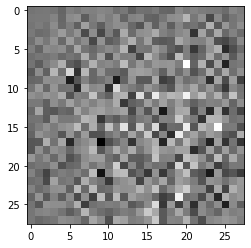

In [2]:
# GAN like in the lecture
# custom loss
# for mnist

import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


# load data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256 # 20: 70s, 256: 56s epoch time

# define training
EPOCHS = 5
latent_dim = 100    # 100: 80s, 10: 70s epoch time
                    # 100: 30s, 10: 30s
num_examples_to_generate = 16

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


"""
The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce
an image from a seed (random noise). Start with a Dense layer that takes this seed
as input, then upsample several times until you reach the desired image size of 28x28x1
"""
def make_generator_model():
    # 256: 140s, 128: 56s, 64: 40s
    depth = 64
    model = tf.keras.Sequential(name="Generator")
    model.add(layers.Dense(7*7*depth, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, depth)))
    assert model.output_shape == (None, 7, 7, depth)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(depth/2, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, depth/2)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(depth/4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, depth/4)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    model.summary()
    return model

# untrained generator
generator = make_generator_model()

latent_vec = tf.random.normal([1, latent_dim])
generated_image = generator(latent_vec, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


# discriminator
# CNN-based image classifier
def make_discriminator_model():
    depth = 16
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Conv2D(depth, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(depth*2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    model.summary()
    return model

# untrained discriminator
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    gl = cross_entropy(tf.ones_like(fake_output), fake_output)
    return gl


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

seed = tf.random.normal([num_examples_to_generate, latent_dim])

@tf.function
def train_step(images):
    latent_vector = tf.random.normal([BATCH_SIZE, latent_dim])
    print("batch size", BATCH_SIZE)
    print("generator input shape", latent_vector.shape )
    print("discriminator input shape", images.shape )

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(latent_vector, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def generate_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()


def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)


    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_images(generator,
                   epochs,
                   seed)


train(train_dataset, EPOCHS)

